## Tutorial 2 - Multi-Class ANNs

###Project Motivation

In the lectures we have seen how Multi-Class Artificial Neural Networks (ANNs) can be trained and tested to classify handwritten digits. To truly appreciate this capability we will see if we can apply our ANN model to work with real images. 

For example given a blank white sheet of paper with a hand written digit on it, how could we use an ANN model to correctly identify the digit. That will be our objective in this tutorial and along the way you will learn a few tricks to speed the training of your models.

### MNIST Multi-Class Classification

To begin, let us load the MNIST dataset and divide it for training and validation. Note that we have left some of the 60,000 samples for final testing of the model.

In [0]:
# obtain data
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26552222.80it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 469677.65it/s]
  1%|          | 16384/1648877 [00:00<00:11, 147231.62it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 7725724.36it/s]                            
8192it [00:00, 192974.78it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


### Multi-Class ANN Architecture
In this example we will be using a 3-layer ANN with ReLU activation functions applied on the first and second hidden layers. The softmax activation will be used for outputting class probabilities and is not included in the architecture setup.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

model = MNISTClassifier()

print('done')

done


### Function to Obtain Accuracy
The get_accuracy function is used to compute the accuracy on training or validation data.

In [0]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total
  
print ('done')

done


### Function to perform Training and Validation
The train function puts everything together. You can provide arguments to adjust the batch size and number of training epochs.

In [0]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    
print('done')

done


### (optional) Sanity Check
Verify that the model is able to overfit on a single batch of data.

500


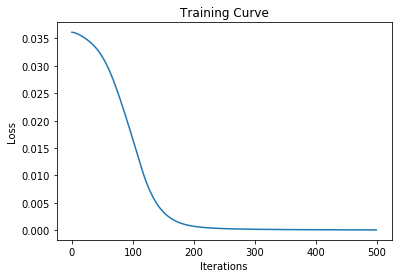

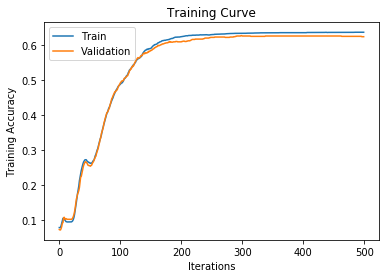

Final Training Accuracy: 0.6357421875
Final Validation Accuracy: 0.623046875
Accuracy on batch of 64:  1.0


In [0]:
#overfitting the model (sanity check)
debug_data = mnist_train[:64]
model = MNISTClassifier()
train(model, debug_data, num_epochs=500)

#obtain accuracy on 64 samples
correct = 0
total = 0
for imgs, labels in torch.utils.data.DataLoader(debug_data, batch_size=64):
    output = model(imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
print('Accuracy on batch of 64: ', correct / total)

Note the Final Training and Validation accuracy is obtained on the full training data and validation data. It does not reflect the performance on the 64 samples that were overfit.

### Run Training and Validation
Now that we've validated that our model can overfit a relatively small amount of training data (i.e. 64 samples), we can proceed to train our model on all of the training data. 

We will be training our model over 5 epochs (how many training iterations is that?) to ensure that we can complete this tutorial in a reasonable time. In your free time you are welcome to explore the model accuracy as you increase the number of epochs.  

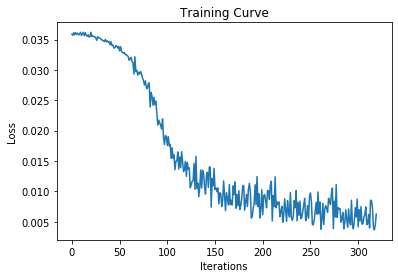

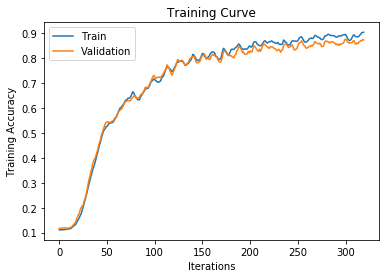

Final Training Accuracy: 0.904296875
Final Validation Accuracy: 0.873046875


In [0]:
#proper model
model = MNISTClassifier()
train(model, mnist_train, num_epochs=5)

### (optional) Additional Training
At this stage we can consider adjusting our model architecture: 
- number of hidden layers, 
- hidden units, 
- activation functions, 
- optimizers, 
- learning rate, 
- momentum, 
- batch size,
- training iterations, 

to evaluate the performance of our ANN model. Can we do better?

**Tip:** Once you have searched through the hyperparameters and found model parameters that work reasonably well. You may want to save your model so that you don't have to retrain the model next time you open the Google Colab file. 

In [0]:
# save the model for next time
torch.save(model.state_dict(), "saved_model")

### Test one image
At this point we have trained our model and observed accuracy scores on the training data and validation data. We haven't really looked at the data. For the next stage of the tutorial we will try to understand what the data looks like and consider what is required to classify new images obtained from the internet, or even our cell phone camera.

image dimensions:  torch.Size([1, 28, 28])
output dimensions:  torch.Size([1, 10])
output probabilities:  tensor([[4.2062e-05, 8.8035e-07, 2.9470e-04, 5.9918e-04, 1.1492e-02, 2.1444e-03,
         1.1598e-05, 8.1460e-02, 7.0450e-03, 8.9691e-01]],
       grad_fn=<SoftmaxBackward>) sum:  tensor(1.0000, grad_fn=<SumBackward0>)
output:  9 with a probability of 0.8969108462333679
label:  9


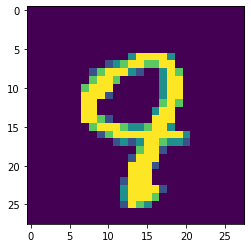

In [0]:
#laod new image for testing
mnist_sample = mnist_data[19120] #samples with indices > 5120 can be used for testing
img, label = list(mnist_sample) #obtain a single image and label

#plot sample image
print('image dimensions: ', img.shape)
plt.imshow(img.view(-1,28)) #make image 28 x 28 (not 1 x 28 x 28 as required by model)

#test new image
out = model(img)
prob = F.softmax(out, dim=1)
print('output dimensions: ', out.shape)
print('output probabilities: ', prob, 'sum: ', torch.sum(prob))

#print max index and compare with label
print('output: ', prob.max(1, keepdim=True)[1].item(), 'with a probability of', prob.max(1, keepdim=True)[0].item())
print('label: ', label)

### Exploring the MNIST data
Before we can load new data for testing we should understand what preprocessing went into making the training data. We will explore:
- Data Type
- Data Dimensions
- Data Normalization
- Orientation

In [0]:
# data type
print(img.dtype)

torch.float32


In [0]:
# data dimensions
print(img.shape)

torch.Size([1, 28, 28])


min val: 0.0   max val: 1.0


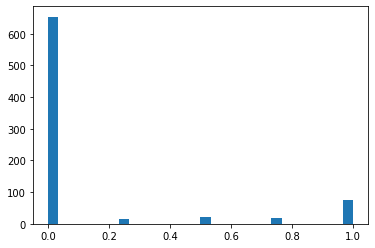

In [0]:
# max and min values
print('min val:', torch.min(img).item(), '  max val:', torch.max(img).item())

#histogram of values
plt.hist(img.view(-1,28*28), bins=30)
plt.show()

Now that we know a little bit about our data we should be able to generate new samples of the data.

### Load New Image
In the Google Colab environment there are a number of ways to load data samples. If you are using Chrome or Chromium you should be able to just load the data into the workspace using the following code. Alternatively, you can always read an image posted online.

In [0]:
#optional for laoding data from a file
from google.colab import files
img_new = files.upload()

In [0]:
#loading data from the internet
img_new = plt.imread('https://www.researchgate.net/profile/Hariton_Costin/publication/311806756/figure/fig1/AS:542753920229376@1506414026147/Sample-of-the-MNIST-dataset-of-handwritten-digits.png')

### Examine the image
How does the image we loaded differ from the one in the MNIST dataset?

In [0]:
print('Image Dimensions:', img_new.shape)
print('Image Type: ', img_new.dtype)

Image Dimensions: (318, 310, 3)
Image Type:  float32


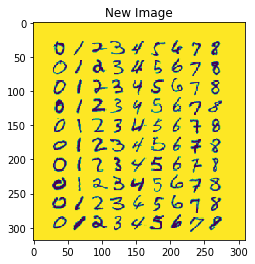

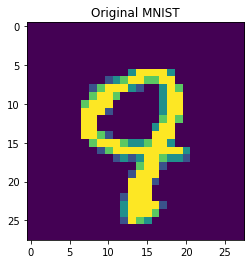

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
  
img_gray = rgb2gray(img_new)

plt.title("New Image")
plt.imshow(img_gray)
plt.show()

# compare to original MNIST image
plt.title("Original MNIST")
plt.imshow(img.view(-1,28)) 

Notice that the image colours are inverated? How will this affect our classification on new data?

### Inverting Colours
One option is to just load an image with the colours inverted.

Image Dimensions (248, 203, 3)


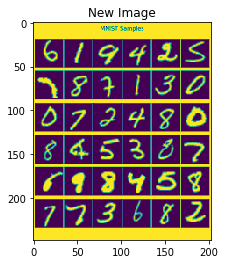

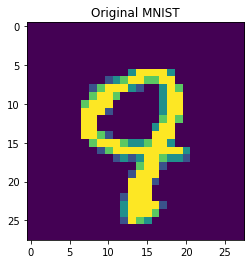

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#load an image with black and white matching the MNIST data
img_new = plt.imread('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT5ZR8ImWkYVd2FRMZgUvCdNkHx0uKjjSAtTEJ0U-x0SPWQFxqnbg')
print('Image Dimensions', img_new.shape)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
  
img_gray = rgb2gray(img_new)

plt.title("New Image")
plt.imshow(img_gray)
plt.show()

# compare to original MNIST image
plt.title("Original MNIST")
plt.imshow(img.view(-1,28)) 

### Cropping the Image
The images used to train our model were centered on the handwritten digit and resized to 28 x 28 pixesl. We will need to do the same to our new data in order for it work with our Multi-Class ANN model.

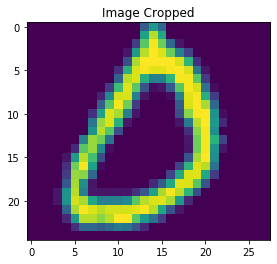

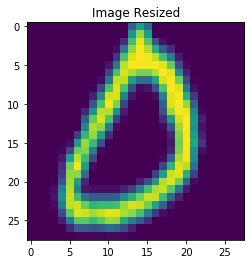

1.0299999999999996
0.0


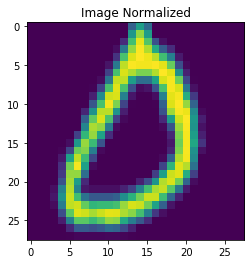

1.0
0.0


In [0]:
#cropping
img_cropped = img_gray[95:120,5:33]
plt.title("Image Cropped")
plt.imshow(img_cropped)
plt.show()

#resize image
from skimage.transform import rescale, resize, downscale_local_mean
img_resized = resize(img_cropped, (28,28), anti_aliasing=True)

#plot resized image
plt.title("Image Resized")
plt.imshow(img_resized)
plt.show()

#image max and min values
print(np.amax(img_resized))
print(np.amin(img_resized))

#normalize to range 0 to 1
img_resized = img_resized / np.amax(img_resized)
plt.title("Image Normalized")
plt.imshow(img_resized)
plt.show()

#verify max and min values
print(np.amax(img_resized))
print(np.amin(img_resized))


If required, how could you invert the colours?

### Testing a New External Image

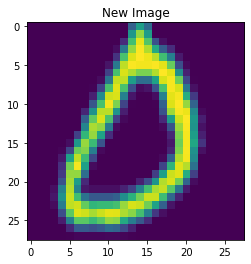

Initial Dimensions:  torch.Size([28, 28])
Updated Dimensions:  torch.Size([1, 28, 28])
output dimensions:  torch.Size([1, 10])
output probabilities:  tensor([[9.4765e-01, 3.3928e-08, 3.1506e-03, 3.1070e-02, 7.8417e-08, 1.5855e-02,
         5.2826e-08, 1.0494e-03, 8.4604e-04, 3.8120e-04]],
       grad_fn=<SoftmaxBackward>) sum:  tensor(1.0000, grad_fn=<SumBackward0>)
Predicted Output:  0 with a probability of 0.947647213935852


In [0]:
#test new external image

#plot resized image
plt.title("New Image")
plt.imshow(img_resized)
plt.show()

#convert image to torch tensor
img_new = torch.tensor(img_resized)
print('Initial Dimensions: ', img_new.shape)

#make our image match the model dimensions 1 x 28 x 28 and tensor type
img_new = img_new.unsqueeze(0).type(torch.FloatTensor)
print('Updated Dimensions: ', img_new.shape)

#perform forward pass on ANN model and generate an output
out = model(img_new)
prob = F.softmax(out, dim=1)

#examine output properties
print('output dimensions: ', out.shape)
print('output probabilities: ', prob, 'sum: ', torch.sum(prob))

#print max index
print('Predicted Output: ', prob.max(1, keepdim=True)[1].item(), 'with a probability of', prob.max(1, keepdim=True)[0].item())

How did our Multi-Class ANN model perform? Was it successful on a new image?

As a little exercise try to load new images and see if the model can classify them correctly. To start you can modify the code above to crop another portion of the image. Once you are comfortable with that, you can look for new images online, or make your own.

**Congratulations! You have just completed a project for handwritten digit recognition**

## Tutorial Challenges
There are just some questions for you to do on your own time.

### Classifications
Obtain all classifications on the validation dataset

In [0]:
#write code to obtain all predictions on the validation data set







### Tutorial Challenge 1: Incorrect Classifications
Go through all the predictions made on the validation dataset. How many digits were incorrectly classified? View the images that were misclassified to see if you would be able to do better. Are there any images that the ANN should have been able to classify? Why do you think it was unsuccessful?

In [0]:
#write code to visualize all incorrectly classified images









### Confusion Matrix
The confusion matrix provide a nice table to visualize the classification performance of your model. Provided below is an example on a 6 sample toy dataset. In the final output the diagonal represents how many samples were correctly classified. For exmaple: if we examine the third row of the result we will see that:

- 1 sample was **incorrectly** classified as class 0
- 0 samples were **incorrectly** classified as class 1
- 2 samples were **correctly** classified as class 2

In [0]:
#Example - Confusion Matrix

from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)


array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

### Tutorial Challenge 2: Confusion Matrix
Continuing with our Multi-Class ANN problem. Generate all the predictions and feed them into a confusion matrix. What insights can you obtain about the performance of your model? Are there certain digits that your model is better able to classify?

In [0]:
#Write code to generate a confusion matrix of our multi-class ANN model









